In [1]:
import numpy as np
from scipy import special
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import fastmat as fm
import fastmat.algorithms as fma

# reference voltage signals
u_l_tx_n = 1

N_el = 32
N_mat = 4

# apodization weights
a_n = np.ones((N_el,1))
#a_n = np.array([np.random.binomial(1,p=0.5) for i in range(N_el)]).reshape(N_el,1)
#a_n[a_n == 0] = -1

# discrete frequencies for Fourier coefficients
#**********************************************************************************************************
T_s = 1 / (20 * (10**6))
q_lb = 1
q_ub = 1648
t_lower = q_lb*T_s
t_upper = q_ub*T_s
l_lower = 215
l_upper = 224
N_f = 10
w_l = (2*np.pi*np.linspace(l_lower,l_upper,N_f)/(t_upper-t_lower)).reshape(1, N_f)
#**********************************************************************************************************

# delay calculation
#**********************************************************************************************************
delta_r_el_one = 304.8*(10**-3)
e_v_one = np.cos(77.6*np.pi/180)
c_ref = 1500
#elements_delay = np.linspace(0, N_el*delta_r_el_one*e_v_one/c_ref, num=N_el, endpoint=False)
elements_delay = np.random.permutation(N_el) * (delta_r_el_one*e_v_one/c_ref)
#elements_delay = np.linspace(0, 0, num=N_el, endpoint=False)
f_clk = 80 * (10**6)
quantized_delay = (np.around(elements_delay*f_clk)*(1/f_clk)).reshape(elements_delay.shape[0], 1)
#**********************************************************************************************************


# Transmitter electromechanical transfer functions accounting for the driving circuits, the cables, and 
# the radiating elements
#**********************************************************************************************************
B_h_frac = 0.7
w_c = 2*np.pi*4*10**6
t_cut = (12*np.log(10))/(w_c*B_h_frac)
a = 3*np.log(10)/(t_cut**2)
#h_m_l = (np.exp(-a*((quantized_delay-t_cut)**2))*(np.cos(w_c*(quantized_delay-t_cut))))/-1j*w_l
h_m_l = np.ones((quantized_delay-t_cut).shape)
#**********************************************************************************************************


# voltage generation (dimension (rows = len(quantized delay) columns = len(w_l)))
#**********************************************************************************************************
u_m_l = u_l_tx_n * np.exp(-1j*w_l*quantized_delay)*a_n
#**********************************************************************************************************

# multiply the affect of transmitter electromechanical transfer functions
v_m_l = np.multiply(u_m_l, h_m_l)

# create x and y distance matrices including all element-xgrid distances (rows: N_grids, columns:N_el) 
# and all element-ygrid distances (rows: N_grids, columns:N_el)
#**********************************************************************************************************
x_grid_num = 64
y_grid_num = 64
xgrid = np.linspace(-20*(10**-3), 20*(10**-3), x_grid_num)
ygrid = np.linspace(20*10**-3 + 40*(10**-3)/y_grid_num, 40*(10**-3), y_grid_num)
rx_grid, ry_grid = np.meshgrid(xgrid, ygrid)
rx_grid_new = rx_grid.reshape(rx_grid.shape[0]*rx_grid.shape[1],1)
ry_grid_new = ry_grid.reshape(ry_grid.shape[0]*ry_grid.shape[1],1)

r_el = np.linspace(-20*(10**-3), 20*(10**-3), N_el*N_mat).reshape(1, N_el*N_mat)

delta_area = r_el[0,1]-r_el[0,0]
delta_volume = (xgrid[1]-xgrid[0])*(ygrid[1]-ygrid[0])

all_x_distances = abs(rx_grid_new-r_el)
all_y_distances = np.tile(ry_grid_new, N_el*N_mat)
#**********************************************************************************************************

def green_function(r, k_l):
    return 1j*special.hankel2(0, k_l*np.linalg.norm(r))/4

# ro value is not given in the paper. assume it is one.
ro_zero = 1

b = 10**(0.217/10)
# (not sure whether sigma 1 or 2) ??
b_line = b/((2*np.pi)**2)
w_ref = w_c
zeta = 2

Fi = np.zeros((N_el , len(xgrid)*len(ygrid)), dtype="complex")


for l in np.arange(N_f):
    
    print(l)
    # excess dispersion term
    if zeta == 1:
        beta_e_ref_l = -2*b_line*w_l[0,l]*np.log(abs(w_l[0,l]/w_ref))/np.pi
    else:
        beta_e_ref_l = b_line*np.tan(2*np.pi/2)*w_l[0,l]*(abs(w_l[0,l])**(zeta-1)-abs(w_ref)**(zeta-1))
    
    # complex valued wave number
    #k_l = (w_l[0,l]/c_ref) + beta_e_ref_l - 1j*b_line*abs(w_l[0,l])**zeta
    k_l = (w_l[0,l]/c_ref)
    
    for k in np.arange(len(xgrid)*len(ygrid)):

        # Transmitter side pressure wave synthesis process
        p_l_m = np.zeros(v_m_l.shape, dtype="complex")
        for i in np.arange(N_el):
            N_mat_box = 0
            for j in np.arange(N_mat):
                N_mat_box = N_mat_box + green_function(np.array([all_x_distances[k,N_mat*i+j], 
                                                                 all_y_distances[k,N_mat*i+j]]), k_l)
            p_l_m[i, l] = v_m_l[i, l] * -1j*2*w_l[0,l]*delta_area*N_mat_box
        p_l_in_n = sum(p_l_m[:, l])
        
        # Receiver side
        for i in np.arange(N_el):
            N_mat_box = 0
            for j in np.arange(N_mat):
                N_mat_box = N_mat_box + green_function(np.array([all_x_distances[k,N_mat*i+j], 
                                                                 all_y_distances[k,N_mat*i+j]]), k_l)
            Fi[i, k] = 2*(k_l**2)*delta_area*delta_volume*p_l_in_n*N_mat_box
    
    if l == 0:
        Fi_matrix = Fi
    else:
        Fi_matrix = np.concatenate((Fi_matrix, Fi), axis=0)


0
1
2
3
4
5
6
7
8
9


In [2]:
import pylops

# sparse solution with spectral projected-gradient for L1 norm
def sparse_solution(gamma_vector, G_all):
    #G_normalized = G_all / np.linalg.norm(G_all, axis=0)
    
    max_A = max(np.linalg.norm(G_all, axis=0))
    W_inv = np.identity(G_all.shape[1])/max_A
    G_normalized = G_all.dot(W_inv)
    
    G_op = pylops.MatrixMult(G_normalized, dtype=np.complex128)
    
    noise = np.random.normal(0, 0.01, N_f*N_el)
    received_signal = G_op*gamma_vector + noise
    
    u_normalized = received_signal/np.linalg.norm(received_signal)
    noise_normalized = noise/np.linalg.norm(received_signal)
    gamma_vector_normalized = gamma_vector/np.linalg.norm(received_signal)
    
    y = G_op*gamma_vector_normalized + noise_normalized

    sparse_signal = np.linalg.norm(received_signal) * W_inv.dot(pylops.optimization.sparsity.spgl1(G_op, y, verbosity=1)[0])
    #sparse_signal = pylops.optimization.sparsity.spgl1(G_op, y, verbosity=1)[0]

    return sparse_signal


SPGL1
No. rows              :      320     
No. columns           :     4096

Initial tau           : 0.00e+00     
Two-norm of b         : 1.00e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     3200



C:\Users\Cakiroglu\AppData\Local\Programs\Python\Python310\lib\site-packages\spgl1\spgl1.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  x *= s.astype(x.dtype)



EXIT -- Found a least-squares solution

Products with A     :     641        Total time   (secs) :     1.5
Products with A^H   :     386        Project time (secs) :     0.2
Newton iterations   :      67        Mat-vec time (secs) :     1.0
Line search its     :     255        Subspace iterations :       0


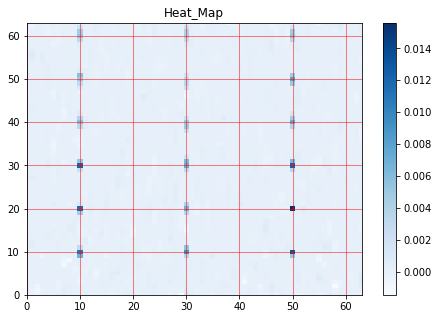

In [3]:
import matplotlib.pyplot as plt

# create compressibility fluctuations (one sparse element)
gamma_vector = np.zeros(Fi_matrix.shape[1], dtype=np.complex128)
#gamma_vector[48*np.array([2*i+1 for i in range(10)])] = 0.3
gamma_vector[np.array([10*64+10, 10*64+30, 10*64+50, 20*64+10, 20*64+30, 20*64+50, 
                       30*64+10, 30*64+30, 30*64+50, 40*64+10, 40*64+30, 40*64+50,
                       50*64+10, 50*64+30, 50*64+50, 60*64+10, 60*64+30, 60*64+50])]  = 0.3

sparse_signal = sparse_solution(gamma_vector, Fi_matrix)
sparse_signal = sparse_signal.reshape(len(xgrid),len(ygrid))

sx = np.linspace(0, len(xgrid)-1, len(xgrid))
sy = np.linspace(0, len(ygrid)-1, len(ygrid))

# plot the figures
fig = plt.figure(figsize = (7.5,5))
fig.subplots_adjust(wspace=0.3)
plt.pcolormesh(sx, sy, np.real(sparse_signal), cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
plt.axis([0, len(xgrid)-1, 0, len(ygrid)-1])
plt.title('Heat_Map')
plt.grid(color='r', linestyle='-', linewidth=0.5)